In [1]:
#####################################
# ICLINK: Link CRSP and IBES        #
# Qingyi (Freda) Song Drechsler     #
# Date: June 2019                   #
# Updated: June 2020                #
#####################################

# This program replicates the SAS macro ICLINK 
# to create a linking table between CRSP and IBES
# Output is a score reflecting the quality of the link
# Score = 0 (best link) to Score = 6 (worst link)
# 
# More explanation on score system:
# - 0: BEST match: using (cusip, cusip dates and company names)       
#          or (exchange ticker, company names and 6-digit cusip)     
# - 1: Cusips and cusip dates match but company names do not match    
# - 2: Cusips and company names match but cusip dates do not match    
# - 3: Cusips match but cusip dates and company names do not match    
# - 4: tickers and 6-digit cusips match but company names do not match   
# - 5: tickers and company names match but 6-digit cusips do not match        
# - 6: tickers match but company names and 6-digit cusips do not match        

In [3]:
from pathlib import Path

import wrds
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz

###################
# Connect to WRDS #
###################
conn=wrds.Connection()


/Users/benkan45d6/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
#########################
# Step 1: Link by CUSIP #
#########################

# 1.1 IBES: Get the list of IBES Tickers for US firms in IBES
_ibes1 = conn.raw_sql("""
                      select ticker, cusip, cname, sdates from ibes.id
                      where usfirm=1 and cusip != ''
                      """, date_cols=['sdates'])

In [5]:
# Create first and last 'start dates' for a given cusip
# Use agg min and max to find the first and last date per group
# then rename to fdate and ldate respectively

_ibes1_date = _ibes1.groupby(['ticker','cusip']).sdates.agg(['min', 'max'])\
.reset_index().rename(columns={'min':'fdate', 'max':'ldate'})

# merge fdate ldate back to _ibes1 data
_ibes2 = pd.merge(_ibes1, _ibes1_date,how='left', on =['ticker','cusip'])
_ibes2 = _ibes2.sort_values(by=['ticker','cusip','sdates'])

# keep only the most recent company name
# determined by having sdates = ldate
_ibes2 = _ibes2.loc[_ibes2.sdates == _ibes2.ldate].drop(['sdates'], axis=1)
_ibes2.head()

,ticker,cusip,cname,fdate,ldate
1,0000,87482X10,TALMER BANCORP,2014-02-20,2014-03-20
6,0001,26878510,EP ENGR CORP,2014-02-20,2019-10-17
7,0004,02504D10,AMERICAN CAPITAL,2014-02-20,2014-02-20
8,000R,14163310,CARECOM,2014-02-20,2014-02-20
9,000V,15117E10,CELLADON,2014-03-20,2014-03-20


In [6]:
# 1.2 CRSP: Get all permno-ncusip combinations
_crsp1 = conn.raw_sql("""
                      select permno, ncusip, comnam, namedt, nameenddt
                      from crsp.stocknames
                      where ncusip != ''
                      """, date_cols=['namedt', 'nameenddt'])

In [7]:
# first namedt
_crsp1_fnamedt = _crsp1.groupby(['permno','ncusip']).namedt.min().reset_index()

# last nameenddt
_crsp1_lnameenddt = _crsp1.groupby(['permno','ncusip']).nameenddt.max().reset_index()

# merge both 
_crsp1_dtrange = pd.merge(_crsp1_fnamedt, _crsp1_lnameenddt, \
                          on = ['permno','ncusip'], how='inner')

# replace namedt and nameenddt with the version from the dtrange
_crsp1 = _crsp1.drop(['namedt'],axis=1).rename(columns={'nameenddt':'enddt'})
_crsp2 = pd.merge(_crsp1, _crsp1_dtrange, on =['permno','ncusip'], how='inner')

# keep only most recent company name
_crsp2 = _crsp2.loc[_crsp2.enddt ==_crsp2.nameenddt].drop(['enddt'], axis=1)


In [8]:
# 1.3 Create CUSIP Link Table

# Link by full cusip, company names and dates
_link1_1 = pd.merge(_ibes2, _crsp2, how='inner', left_on='cusip', right_on='ncusip')\
.sort_values(['ticker','permno','ldate'])


In [9]:
# Keep link with most recent company name
_link1_1_tmp = _link1_1.groupby(['ticker','permno']).ldate.max().reset_index()
_link1_2 = pd.merge(_link1_1, _link1_1_tmp, how='inner', on =['ticker', 'permno', 'ldate'])


In [10]:
# Calculate name matching ratio using FuzzyWuzzy

# Note: fuzz ratio = 100 -> match perfectly
#       fuzz ratio = 0   -> do not match at all

# Comment: token_set_ratio is more flexible in matching the strings:
# fuzz.token_set_ratio('AMAZON.COM INC',  'AMAZON COM INC')
# returns value of 100

# fuzz.ratio('AMAZON.COM INC',  'AMAZON COM INC')
# returns value of 93

_link1_2['name_ratio'] = _link1_2.apply(lambda x: fuzz.token_set_ratio(x.comnam, x.cname), axis=1)

# Note on parameters:
# The following parameters are chosen to mimic the SAS macro %iclink
# In %iclink, name_dist < 30 is assigned score = 0
# where name_dist=30 is roughly 90% percentile in total distribution
# and higher name_dist means more different names.
# In name_ratio, I mimic this by choosing 10% percentile as cutoff to assign
# score = 0

# 10% percentile of the company name distance
name_ratio_p10 = _link1_2.name_ratio.quantile(0.10)
name_ratio_p10

67.0

In [11]:
# Function to assign score for companies matched by:
# full cusip and passing name_ratio
# or meeting date range requirement

def score1(row):
    if (row['fdate']<=row['nameenddt']) & (row['ldate']>=row['namedt']) & (row['name_ratio'] >= name_ratio_p10):
        score = 0
    elif (row['fdate']<=row['nameenddt']) & (row['ldate']>=row['namedt']):
        score = 1
    elif row['name_ratio'] >= name_ratio_p10:
        score = 2
    else:
        score = 3
    return score

# assign size portfolio
_link1_2['score']=_link1_2.apply(score1, axis=1)
_link1_2 = _link1_2[['ticker','permno','cname','comnam','name_ratio','score']]
_link1_2 = _link1_2.drop_duplicates()

In [12]:
_link1_2.groupby(['score']).score.count()

score
0    18693
1     1809
2      707
3       78
Name: score, dtype: int64

In [13]:
##########################
# Step 2: Link by TICKER #
##########################

# Find links for the remaining unmatched cases using Exchange Ticker 

# Identify remaining unmatched cases 
_nomatch1 = pd.merge(_ibes2[['ticker']], _link1_2[['permno','ticker']], on='ticker', how='left')
_nomatch1 = _nomatch1.loc[_nomatch1.permno.isnull()].drop(['permno'], axis=1).drop_duplicates()


In [14]:
# Add IBES identifying information

ibesid = conn.raw_sql(""" select ticker, cname, oftic, sdates, cusip from ibes.id """, date_cols=['sdates'])
ibesid = ibesid.loc[ibesid.oftic.notna()]

_nomatch2 = pd.merge(_nomatch1, ibesid, how='inner', on=['ticker'])
_nomatch2.shape

(16823, 5)

In [15]:
# Create first and last 'start dates' for Exchange Tickers
# Label date range variables and keep only most recent company name

_nomatch3 = _nomatch2.groupby(['ticker', 'oftic']).sdates.agg(['min', 'max'])\
.reset_index().rename(columns={'min':'fdate', 'max':'ldate'})

_nomatch3 = pd.merge(_nomatch2, _nomatch3, how='left', on=['ticker','oftic'])

_nomatch3 = _nomatch3.loc[_nomatch3.sdates == _nomatch3.ldate]
_nomatch3.shape

(8530, 7)

In [16]:
# Get entire list of CRSP stocks with Exchange Ticker information

_crsp_n1 = conn.raw_sql(""" select ticker, comnam, permno, ncusip, namedt, nameenddt
                            from crsp.stocknames """, date_cols=['namedt', 'nameenddt'])

_crsp_n1 = _crsp_n1.loc[_crsp_n1.ticker.notna()].sort_values(by=['permno','ticker','namedt'])

In [17]:
# Arrange effective dates for link by Exchange Ticker

_crsp_n1_namedt = _crsp_n1.groupby(['permno','ticker']).namedt.min().reset_index().rename(columns={'min':'namedt'})
_crsp_n1_nameenddt = _crsp_n1.groupby(['permno','ticker']).nameenddt.max().reset_index().rename(columns={'max':'nameenddt'})

_crsp_n1_dt = pd.merge(_crsp_n1_namedt, _crsp_n1_nameenddt, how = 'inner', on=['permno','ticker'])

_crsp_n1 = _crsp_n1.rename(columns={'namedt': 'namedt_ind', 'nameenddt':'nameenddt_ind'})

In [18]:
_crsp_n2 = pd.merge(_crsp_n1, _crsp_n1_dt, how ='left', on = ['permno','ticker'])

_crsp_n2 = _crsp_n2.rename(columns={'ticker':'crsp_ticker'})
_crsp_n2 = _crsp_n2.loc[_crsp_n2.nameenddt_ind == _crsp_n2.nameenddt].drop(['namedt_ind', 'nameenddt_ind'], axis=1)

In [19]:
# Merge remaining unmatched cases using Exchange Ticker 
# Note: Use ticker date ranges as exchange tickers are reused overtime

_link2_1 = pd.merge(_nomatch3, _crsp_n2, how='inner', left_on=['oftic'], right_on=['crsp_ticker'])
_link2_1 = _link2_1.loc[(_link2_1.ldate>=_link2_1.namedt) & (_link2_1.fdate<=_link2_1.nameenddt)]


In [20]:
# Score using company name using 6-digit CUSIP and company name spelling distance
_link2_1['name_ratio'] = _link2_1.apply(lambda x: fuzz.token_set_ratio(x.comnam, x.cname), axis=1)

_link2_2 = _link2_1
_link2_2['cusip6'] = _link2_2.apply(lambda x: x.cusip[:6], axis=1)
_link2_2['ncusip6'] = _link2_2.apply(lambda x: x.ncusip[:6], axis=1)


In [21]:
# Score using company name using 6-digit CUSIP and company name spelling distance

def score2(row):
    if (row['cusip6']==row['ncusip6']) & (row['name_ratio'] >= name_ratio_p10):
        score = 0
    elif (row['cusip6']==row['ncusip6']):
        score = 4
    elif row['name_ratio'] >= name_ratio_p10:
        score = 5
    else:
        score = 6
    return score

# assign size portfolio
_link2_2['score']=_link2_2.apply(score2, axis=1)

In [22]:
# Some companies may have more than one TICKER-PERMNO link
# so re-sort and keep the case (PERMNO & Company name from CRSP)
# that gives the lowest score for each IBES TICKER 

_link2_2 = _link2_2[['ticker','permno','cname','comnam', 'name_ratio', 'score']].sort_values(by=['ticker','score'])
_link2_2_score = _link2_2.groupby(['ticker']).score.min().reset_index()

_link2_3 = pd.merge(_link2_2, _link2_2_score, how='inner', on=['ticker', 'score'])
_link2_3 = _link2_3[['ticker','permno','cname','comnam','score']].drop_duplicates()

In [23]:
#####################################
# Step 3: Finalize LInks and Scores #
#####################################

iclink = _link1_2.append(_link2_3)


/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_12867/3666966128.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iclink = _link1_2.append(_link2_3)


In [24]:
# Storing iclink for other program usage

iclink.to_csv('iclink.csv')

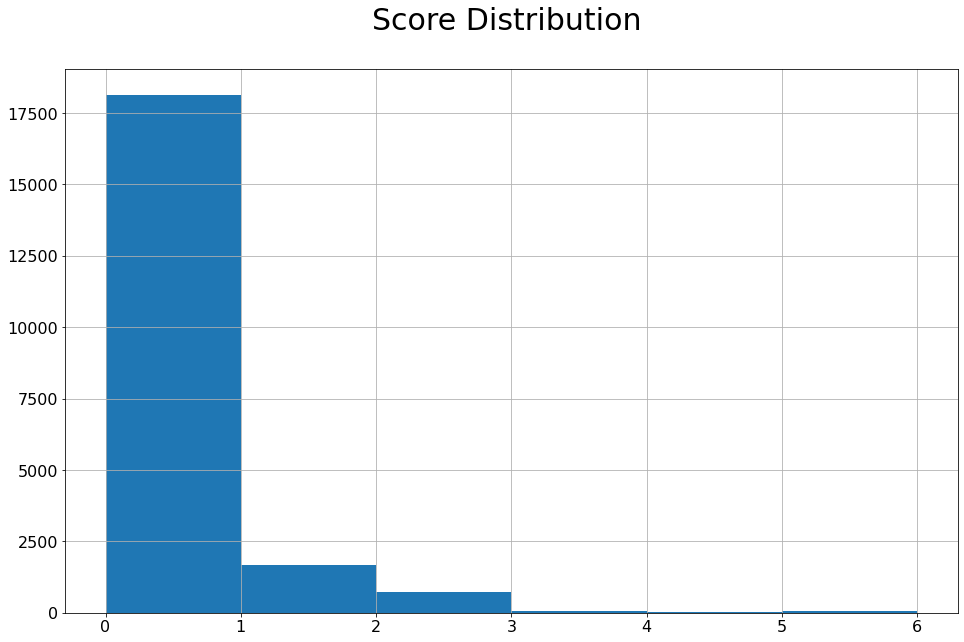

In [25]:
# Plotting summary statistics output:

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,10))
plt.title('Score Distribution \n', fontsize=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
iclink.score.hist(bins=6)

plt.savefig(Path.home().joinpath('iclink_score.png'))

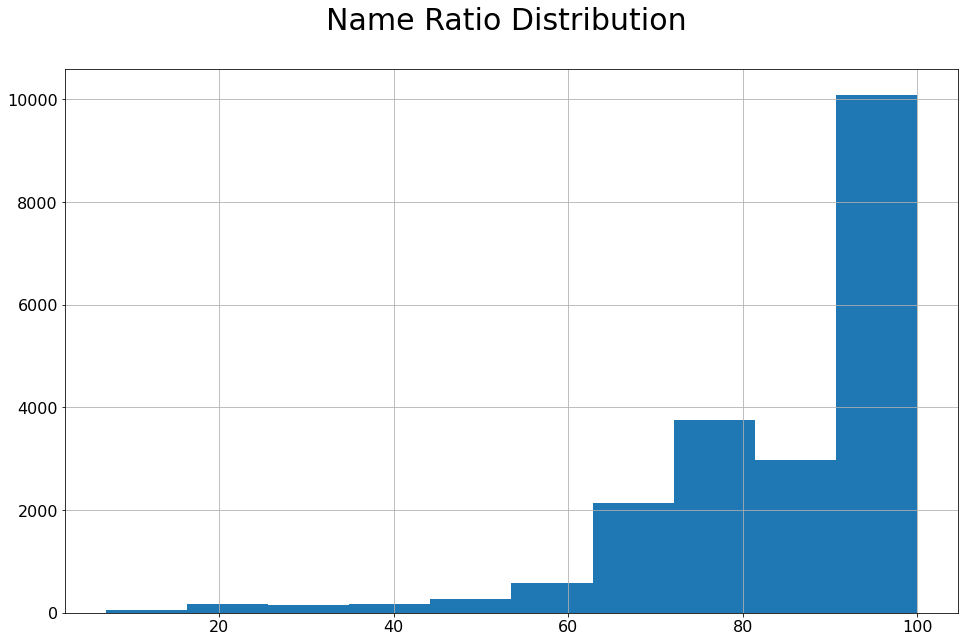

In [26]:

%matplotlib inline

plt.figure(figsize=(16,10))
plt.title('Name Ratio Distribution \n', fontsize=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
iclink.name_ratio.hist()

plt.savefig(Path.home().joinpath('iclink_name_ratio.png'))

In [27]:
sample_out = iclink.loc[(iclink.permno==58827) | (iclink.permno==11081) | \
           (iclink.permno==75161) | (iclink.permno==12490) | \
           (iclink.permno==10107)]

sample_out[['permno', 'name_ratio']] = sample_out[['permno', 'name_ratio']].astype(int)
sample_out = sample_out[['ticker', 'permno','cname','comnam', 'name_ratio', 'score']]

sample_out

/usr/local/sas/jupyterhub/dev/venvs/20210519/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,ticker,permno,cname,comnam,name_ratio,score
2399,BAC,58827,BANKAMERICA CA,BANKAMERICA CORP,88,0
5498,DELL,11081,DELL INC,DELL INC,100,0
7108,FFS,75161,1ST FED BCP DEL,FIRST FEDERAL BANCORP DE,51,3
9386,IBM,12490,IBM,INTERNATIONAL BUSINESS MACHS CO,12,1
12341,MSFT,10107,MICROSOFT,MICROSOFT CORP,100,0
